<div align="right" style="text-align: right"><i>Peter Norvig<br>August 2021</i></div>

# RaceTrack

From 538's [The Riddler](https://fivethirtyeight.com/features/can-you-zoom-around-the-race-track/) on 6 August 2021 (slightly edited):

> The game of [RaceTrack](https://link.springer.com/chapter/10.1007/978-3-642-13122-6_26) was published by recreational mathematician [Martin Gardner](http://www.martin-gardner.org/) in [1973](https://www.scientificamerican.com/article/mathematical-games-1973-01/). There have been some neat [digital versions](https://harmmade.com/vectorracer/#) since then, and it’s high time we had a race here: the Riddler-opolis 500!
>
> You begin at the blue point on the starting line below the circle (diagram shown below) with a velocity vector of zero, and your goal is to circumnavigate the track in a counterclockwise loop. You’ll be moving from point to point on the grid, without ever crashing into the outer wall or the central circle.  (Moving tangent to the circle is allowed, as is being on a grid point along a wall.)
>
> For each move you have a choice of nine possible destinations, corresponding to the 3x3 grid that surrounds the point formed by adding your current velocity vector to your current position. That is, you can maintain your current velocity, or you can alter your velocity (and hence your destination) by accelerating one grid point in any direction (horizontally, vertically or diagonally). For example, if your first move was up and to the right, then your nine possible second moves are shown below, although two of them will cause you to crash into the central circle.
>
> ![](https://fivethirtyeight.com/wp-content/uploads/2021/08/Screen-Shot-2021-08-04-at-10.44.11-PM.png?w=400)
>
> How quickly can you navigate the track? 
>


# Defining Points and the Track

I will start by defining the following:
- `Point(x, y)`: a point in the 2-D plane, implemented as a complex number.
- `Path`: a list of points representing the car's positions as it moves.
- `track`: all the legal grid points on the race track.
- `start`: the single starting point.
- `zero`: a zero vector (your starting velocity vector).
- `radius`: the radius of the central circle (whose center is defined as the origin).
- `accelerations`: the nine possible acceleration vectors, to changes the car's velocity.
- `X(point)`, `Y(point)`: the x- and y-coordinates of a point, respectively.
- `velocity(path)`: the car's current velocity when it has just made the last move in a path.

In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple

Point  = Vector = complex
Path   = List[Point]
track  = {Point(x, y) for x in range(-7, 8) for y in range(-7, 8) if abs(Point(x, y)) >= 3}
start  = Point(0, -5)
zero   = Vector(0, 0)
radius = 3
accelerations = [Vector(x, y) for y in (1, 0, -1) for x in (-1, 0, 1)]

def X(point) -> float: return point.real
def Y(point) -> float: return point.imag

def velocity(path) -> Vector:
    """Velocity of the car at the end of the path."""
    return zero if len(path) == 1 else path[-1] - path[-2]  

# Visualization

I think it will be helpful now to introduce a way to visualize the racetrack and the path(s) on it:

In [2]:
def plot(paths=(), finish=[Point(0, -3), Point(0, -7)]):
    """Plot the track and any paths, along with the start and finish line."""
    fig, ax = plt.subplots()
    plt.xticks([]); plt.yticks([])
    ax.set_aspect('equal');
    ax.add_artist(plt.Circle((0, 0), 3, alpha=0.1, color='k', ec='w'))
    ax.plot(*XY(track), 'k,' )          # grid points
    ax.plot(*XY([start]), 'ks', ms=10)  # start point
    ax.plot(*XY(finish), 'k:')          # finish line
    for path in paths:                  # paths
        ax.plot(*XY(path), 'o-')  
    plt.title(f'{len(paths)} paths of {set(len(path) - 1 for path in paths)} moves')
    
def XY(points) -> Tuple[List[float], List[float]]: 
    """A tuple of: (the x-coordinates of points, the y-coordinates of points)."""
    return [X(p) for p in points], [Y(p) for p in points]

Below is my replication of The Riddler's diagram above: the first move goes up and to the right, and there are nine paths for the second move (two of which crash into the central circle).

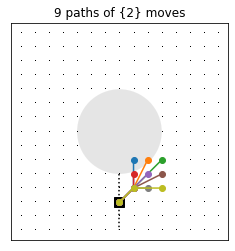

In [3]:
path1 = [start, Point(1, -4)]
paths = [path1 + [Point(path1[-1] + velocity(path1) + a)] 
         for a in accelerations]
plot(paths)

# Circumnavigating the Track

The goal of the race is to circumnavigate the center circle. I can test for that by seeing if the path goes from the fourth [quadrant](https://mathworld.wolfram.com/Quadrant.html) to the first, second, third, and back to the fourth. The function `is_complete(path)` does that.

If you want to generalize this to other race tracks, you can change the definition of `quadrant` (there could be more than 4 quadrants/regions, and they could have any shape), and change the `regions` in the parameter list of `is_complete`.

In [4]:
def is_complete(path, regions=(4, 1, 2, 3, 4)) -> bool:
    """Does the path go through all the regions in the prescribed order?"""
    i = 0
    for p in path:
        if quadrant(p) == regions[i]:
            i += 1
            if i == len(regions):
                return True
    return False

def quadrant(p: Point) -> int: 
    """What quadrant of the 2-D plane is this point in?"""
    if X(p) >= 0:
        return 1 if Y(p) >= 0 else 4
    else:
        return 2 if Y(p) >= 0 else 3

# Legal Moves

I'm considering how to solve for our specific central-circle-track, and also make the code general enough that it can handle other tracks. I'll do that by splitting up responsibility for determining legal moves:
- `all_moves(path)` is general; it considers points with all 9 accelerations and returns the points that are on the track.
- `circle_track_moves(path)` is specific; it limits moves in the following ways:
  - It won't let a move intersect the center circle (even if the start and end points of a move are outside the circle).
  - It won't make moves that stay in one place (they are legal, but wasteful and not needed on this track).
  - It won't pass from the fourth quadrant backwards into the third (such moves are legal, but wasteful).
  
In the code below `p` is the previous point on a path, `p1` is where the next point would be if the velocity remained constant, and `p2` is the point we arrive at when acceleration is applied.

In [5]:
def all_moves(path) -> List[Point]:
    """Moves with any allowable acceleration that end up on the track."""
    p1: Point = path[-1] + velocity(path)
    return {(p1 + a) for a in accelerations} & track
                
def circle_track_moves(path) -> List[Point]:
    """Reasonable moves on the circle track."""
    p = path[-1]
    return [p2 for p2 in all_moves(path)
            if p2 != p
            and not (quadrant(p) == 4 and quadrant(p2) == 3) # Don't go backwards over finish line
            and not intersects_circle(p, p2)]

def intersects_circle(p: Point, p2: Point, center=zero, radius=radius, N=20) -> bool:
    """Does a line from p to p2 intersect a circle with given center and radius?"""
    return any(abs(q - center) < radius for q in waypoints(p, p2, N))

def waypoints(p, p2, N) -> List[Point]:
    """All the points that are i/N of the way from p to p2"""
    return [p + (i / N) * (p2 - p)
            for i in range(N + 1)]

The math for solving for the intersection of a line segment and a circle looked [complicated](https://stackoverflow.com/questions/6091728/line-segment-circle-intersection), so instead I just define N+1 points along the line from point *p* to point *p2* and ask if any of those points is within the radius of the circle. If N is too small this could miss an intersection, but on the small grid for this race track, it shouldn't be a problem.

# A Frontier of Possible Paths

Now I want to expand paths by adding legal moves to the end until I find complete path(s). I could keep all my paths in a `list`, but there will be an exponential number of them (up to 9<sup><i>n<i/></sup> paths of length *n* and it looks like *n* will be around 10 to 13).

Instead I will keep track of a `frontier`, which I define as a mapping of `{(endpoint, velocity): path}`. The idea is that there may be many paths that arrive at the some endpoint with the same velocity in the same number of moves, but if so, the best continuation of all of them will be the same, so I only need to keep one of them. 
    
*Note:* Before I added the limitation that moves can't pass backwards from the fourth quadrant to the third, I had a bug: sometimes the frontier would capture a `(endpoint, velocity)` pair for a path that was in the third quadrant but hadn't circumnavigated and was replacing a path to the same point that had circumnavigated. This meant that I was discarding some valid paths.

In [6]:
def expand(frontier, legal_moves=circle_track_moves) -> dict:
    """The {(endpoint, velocity): path} frontier extended one move in all legal ways."""
    return {(p, velocity([path[-1], p])): path + [p] 
            for path in frontier.values() 
            for p in legal_moves(path)}

# Searching for Fastest Complete Paths

Now all I have to do to solve the problem is repeatedly expand the frontier until some path(s) are complete. The first completed paths found are guaranteed to be the fastest (i.e., have the fewest moves), because we are expanding one move at a time. In the end, I return a list of all the completed paths in the frontier, but there may be many other paths that are not returned, because the frontier only keeps one path for each `(endpoint, velocity)` pair along the way. 

In [7]:
def search(path=[start], legal_moves=circle_track_moves) -> List[Path]:
    """Find the shortest possible complete path(s)."""
    frontier = {(path[-1], velocity(path)): path}
    complete_paths = []
    while not complete_paths:
        frontier  = expand(frontier, legal_moves)
        complete_paths = list(filter(is_complete, frontier.values()))
    return complete_paths

# Solutions

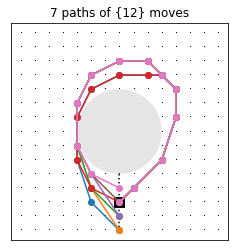

In [8]:
solutions = search([start])

plot(solutions)

We see that the fastest path takes 12 moves, and there are 7 ways to get there (with other ways discarded).

# Submitting your Answer

I'll need a bit of work to put my answers into the form requested by The Riddler:

> Finally, submitting your answer can be tricky work. Please be sure to submit both your total time, as well as your sequence of moves. Each move should be assigned a digit from 1 through 9, corresponding to the nine possible destinations of the move:
>
>     1 2 3
>     4 5 6
>     7 8 9

I will define two functions to translate back and forth between my `Path` and The Riddler's list of `Digits`: 

In [9]:
Digits = List[int] # each int is 1-9

def digits_from_path(path) -> Digits:
    """The digits that the path represents."""
    return [1 + accelerations.index(velocity(path[:i + 1]) - velocity(path[:i]))
            for i in range(1, len(path))]

def path_from_digits(digits, start=start) -> Path:
    """The path that the digits represent."""
    v = zero # Velocity
    path = [start]
    for d in digits:
        v += accelerations[d - 1]
        path.append(v + path[-1])
    return path

In [10]:
[digits_from_path(path) for path in solutions]

[[3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 6, 3],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 6],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 3],
 [3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 3, 3],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 9],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 6],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 3]]

# Alternative Solutions

We can search from five different two-move opening sequences and one five-move sequence, and get different solution paths. Every solution is 12 moves. I don't understand why every plot has exactly 7 solution paths; I suppose it is because the finish line is crowded and there are only so many ways to get there.

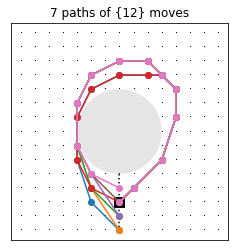

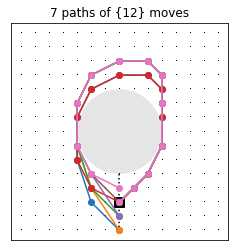

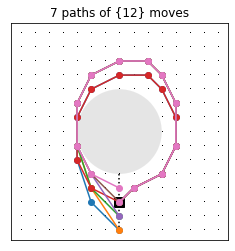

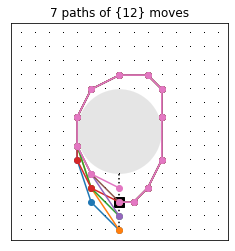

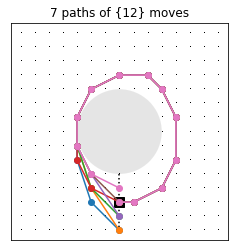

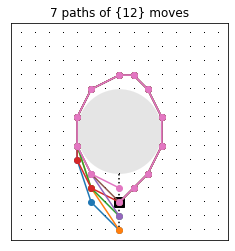

In [11]:
openings = [3, 3], [3, 5], [3, 6], [6, 2], [6, 3], [3, 5, 2, 4, 4]
for digits in openings:
    plot(search(path_from_digits(digits)))

# Tests and Visualizations

Below are a few unit tests; there should be more.

Here are three tests/visualizations for `intersects_circle`:

In [12]:
def test_intersects(expected: bool, segments: List[Path]):
    """Test if segments do the expected thing with `intersects_circle`."""
    plot(segments, finish=[])
    for p, q in segments:
        assert intersects_circle(p, q) is expected

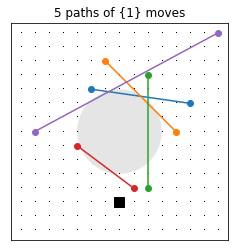

In [13]:
test_intersects(True, [ # Line segments that intersect the circle
    [Point(-2, 3), Point(5, 2)], 
    [Point(-1, 5), Point(4, 0)], 
    [Point(2, 4),  Point(2, -4)],
    [Point(-3, -1),Point(1, -4)],
    [Point(-6, 0), Point(7, 7)]])

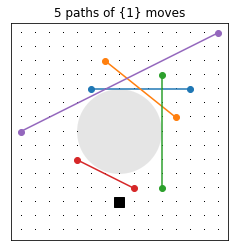

In [14]:
test_intersects(False, [ # Line segments that do not intersect the circle
    [Point(-2, 3), Point(5, 3)], 
    [Point(-1, 5), Point(4, 1)], 
    [Point(3, 4),  Point(3, -4)],
    [Point(-3, -2),Point(1, -4)],
    [Point(-7, 0), Point(7, 7)]])

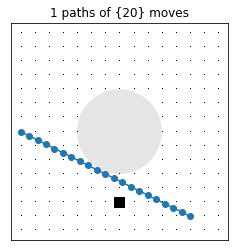

In [15]:
# The waypoints that are checked to see if they are outside the circle
p, q = Point(-7, 0), Point(5, -6)
plot([waypoints(p, q, 20)], finish=[])
assert not intersects_circle(p, q)

Here's a visualization for `expand(frontier)` showing the first few expansions.
Note that the growth in number of paths is much slower then 9<sup><i>n</i></sup>.

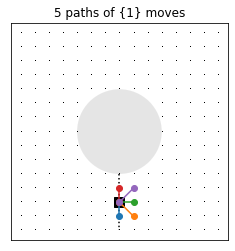

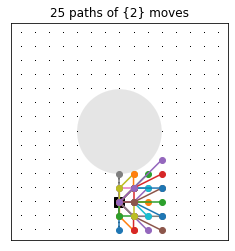

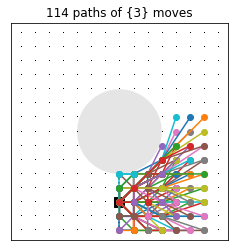

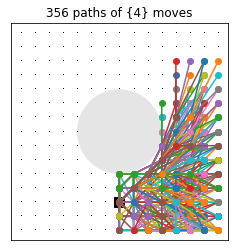

In [16]:
frontier = {(start, zero): [start]}

for i in range(4):
    frontier = expand(frontier)
    plot(frontier.values())

Additional tests:

In [17]:
assert start == Point(0, -5) == 0-5j
assert path1 == [start, Point(1, -4)] == [0-5j, 1-4j]

assert X(start) == 0 and Y(start) == -5 
assert velocity([start]) == 0
assert velocity(path1) == Vector(1, 1)
assert XY(path1) == ([0, 1], [-5, -4])

assert quadrant(start) == 4
assert quadrant(Point(1, 2)) == 1
assert quadrant(Point(-5, 4)) == 2
assert quadrant(Point(-1, -1)) == 3

assert waypoints(0, 10, 10) == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
assert waypoints(zero, Point(10, 20), 10) == [
    0j,1+2j,2+4j,3+6j,4+8j,5+10j,6+12j,7+14j,8+16j,9+18j,10+20j]

# There are 9 moves from the start point
assert all_moves([start]) == {-1-4j, -1-5j,  -1-6j, 
                               0-4j,  0-5j,   0-6j, 
                               1-4j,  1-5j,   1-6j}

# But 3 moves are backwards and 1 stays in the same place; those are disallowed
assert circle_track_moves([start]) == [0-6j, 1-6j, 1-5j, 0-4j, 1-4j]
assert expand({(start, zero): [start]}) == {
 (0-6j, 0-1j): [0-5j, 0-6j],
 (1-6j, 1-1j): [0-5j, 1-6j],
 (1-5j, 1+0j): [0-5j, 1-5j],
 (0-4j, 0+1j): [0-5j, 0-4j],
 (1-4j, 1+1j): [0-5j, 1-4j]}

for path in solutions:
    digits = digits_from_path(path)
    assert path   == path_from_digits(digits_from_path(path))   # Inverses
    assert digits == digits_from_path(path_from_digits(digits)) # Inverses

'tests pass'

'tests pass'